# **Multiclass classification model using a custom convolutional neural network in TensorFlow**

**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip gdrive/MyDrive/CNN_assignment

!unzip "/content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip" -d "/content/drive/MyDrive/Colab Notebooks/CNN_assignment"

Archive:  /content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip
replace /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
replace /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflati

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')


In [ ]:
# Defining the path for train and test images
#data_dir_train = pathlib.Path(r"C:\Users\likhi\OneDrive\Desktop\Case study\Melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Train")
#data_dir_test = pathlib.Path(r"C:\Users\likhi\OneDrive\Desktop\Case study\Melanoma\Skin cancer ISIC The International Skin Imaging Collaboration\Test")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
validation_split = 0.2
seed_train_validation = 123
shuffle_value = True

Use 80% of the images for training, and 20% for validation.

In [ ]:
#Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size = (img_height, img_width),
                                                               validation_split = validation_split,
                                                               subset = "training",
                                                               seed = seed_train_validation,
                                                               color_mode = 'rgb',
                                                               shuffle = shuffle_value)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir_train,
                                                             batch_size=batch_size,
                                                             image_size = (img_height, img_width),
                                                             validation_split = validation_split,
                                                             subset = "validation",
                                                             seed = seed_train_validation,
                                                             color_mode = 'rgb',
                                                             shuffle = shuffle_value)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


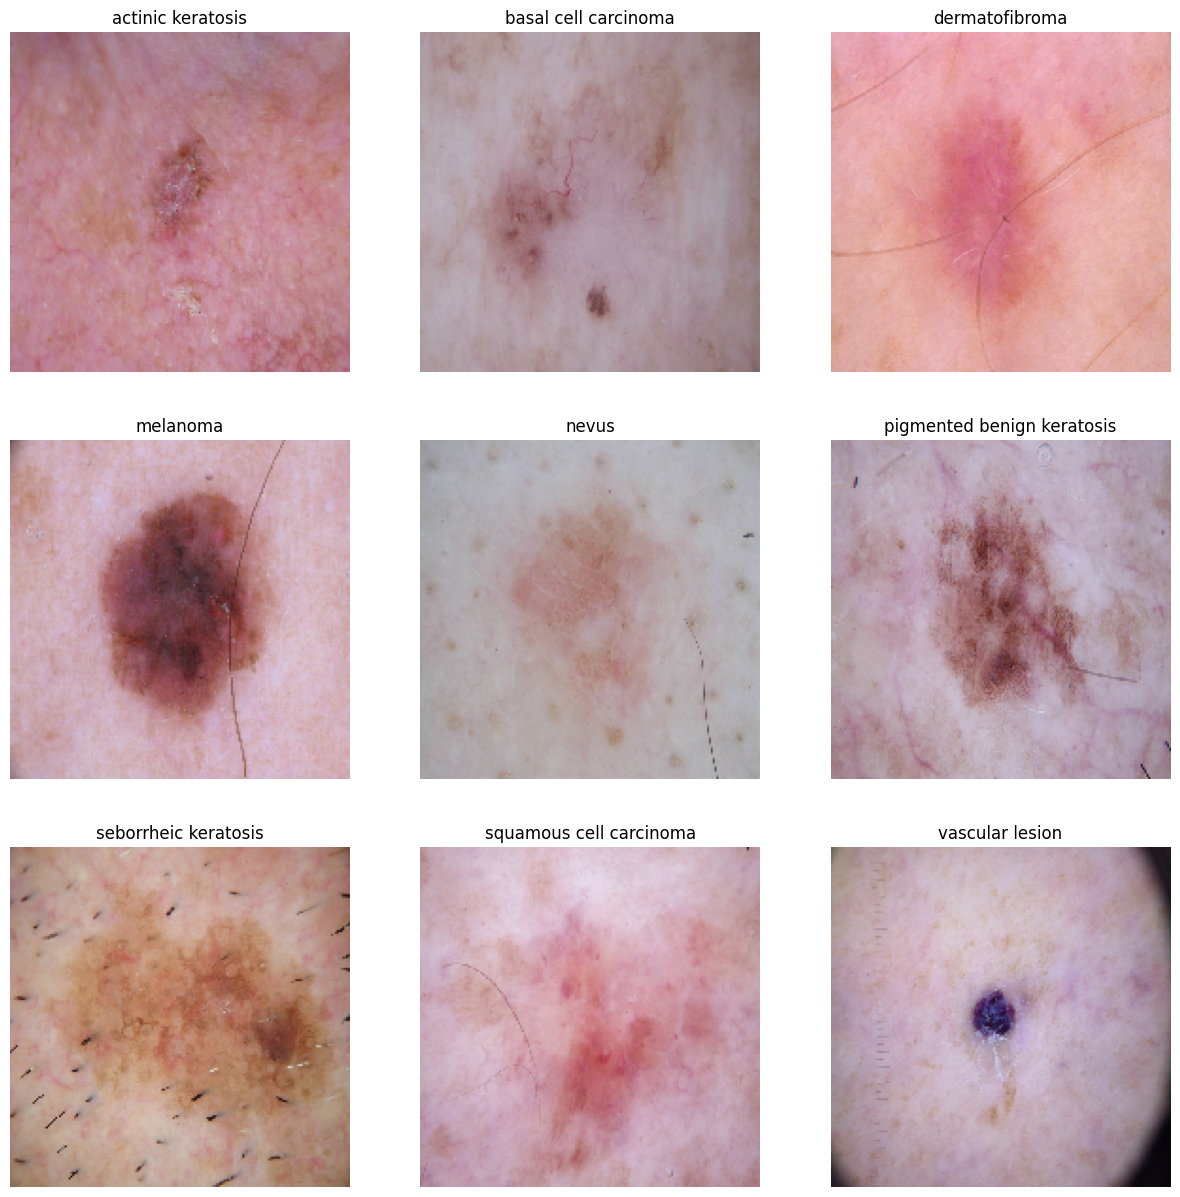

In [ ]:
import matplotlib.pyplot as plt
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model 1
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

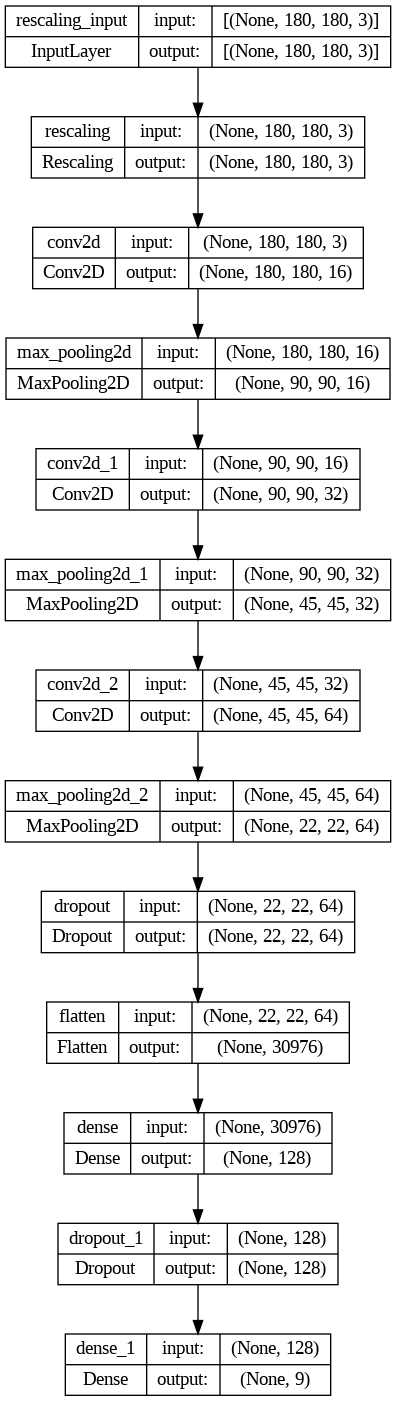

In [ ]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Compile the model 1
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model 1

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 56s 1s/step - loss: 0.7622 - accuracy: 0.7132 - val_loss: 1.8664 - val_accuracy: 0.4720
Epoch 2/20
56/56 [==============================] - 57s 1s/step - loss: 0.7684 - accuracy: 0.7104 - val_loss: 1.6668 - val_accuracy: 0.5324
Epoch 3/20
56/56 [==============================] - 57s 1s/step - loss: 0.7187 - accuracy: 0.7294 - val_loss: 1.6540 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 55s 983ms/step - loss: 0.6693 - accuracy: 0.7511 - val_loss: 1.7424 - val_accuracy: 0.5548
Epoch 5/20
56/56 [==============================] - 56s 998ms/step - loss: 0.6598 - accuracy: 0.7556 - val_loss: 1.8002 - val_accuracy: 0.5682
Epoch 6/20
56/56 [==============================] - 57s 1s/step - loss: 0.6298 - accuracy: 0.7640 - val_loss: 1.8458 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 54s 970ms/step - loss: 0.6258 - accuracy: 0.7634 - val_loss: 1.9495 - val_accuracy: 0.5459
Epoch 8/20


### Visualizing training results

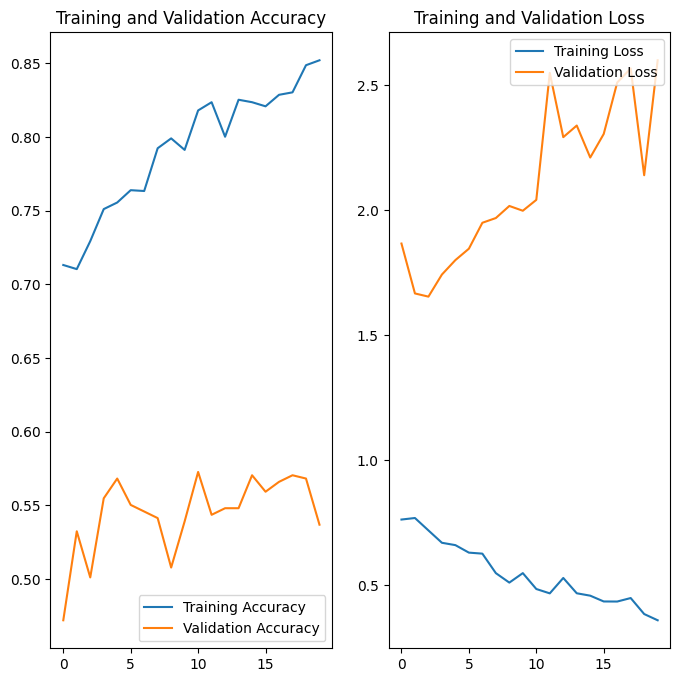

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As per above graph the model is overfitting where trainig acc = 70% and validation acc = 55%.

### Distribution of data in each class

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           438
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           139

### Write your findings here

 Yes the model tends to overfit below are the reasons:

      *There is lot of imbalance in data which is the main reason for decreasing in accuracy.
      *Need to add some more sample data so we have adequate data to train a model

In [ ]:
#The model is overfit as we can observe the trainig accuracy is grater than 70 and testing accuracy is near to 40.
#And also the testing  loss is almost twice the trainig loss.

In [ ]:
# Choosing DataAugmentation strategy
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    tf.keras.layers.RandomCrop(img_height,img_width),
  ]
)

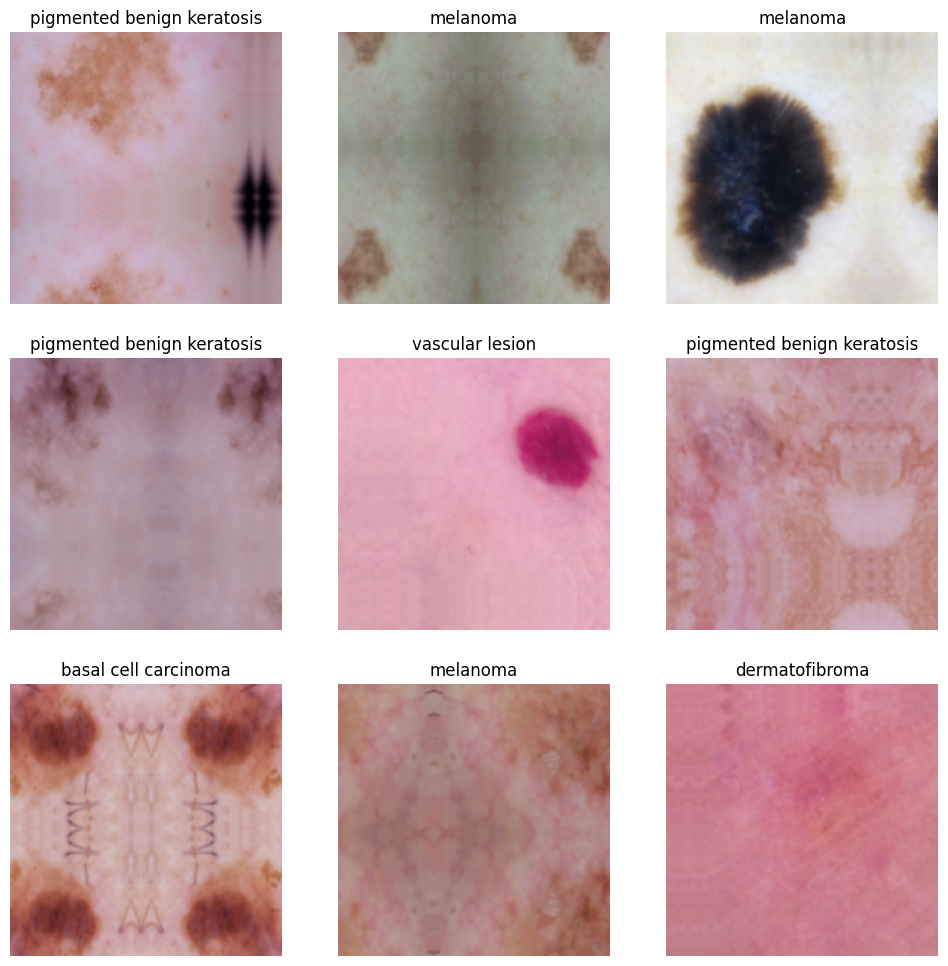

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model 2

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3), padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3), padding='same',activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)      

### **Compiling the model 2**

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 128)      

### **Training the model 2**

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 127s 2s/step - loss: 2.1116 - accuracy: 0.2439 - val_loss: 1.8857 - val_accuracy: 0.2886
Epoch 2/20
56/56 [==============================] - 125s 2s/step - loss: 1.7374 - accuracy: 0.3599 - val_loss: 1.6192 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 145s 3s/step - loss: 1.5618 - accuracy: 0.4637 - val_loss: 1.4642 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 124s 2s/step - loss: 1.4256 - accuracy: 0.5106 - val_loss: 1.4567 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 122s 2s/step - loss: 1.3582 - accuracy: 0.5167 - val_loss: 1.4279 - val_accuracy: 0.5011
Epoch 6/20
56/56 [==============================] - 125s 2s/step - loss: 1.3326 - accuracy: 0.5240 - val_loss: 1.4130 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 129s 2s/step - loss: 1.2795 - accuracy: 0.5513 - val_loss: 1.3876 - val_accuracy: 0.5481
Epoch 8/20
56/56 [======

### **Visualizing the results**

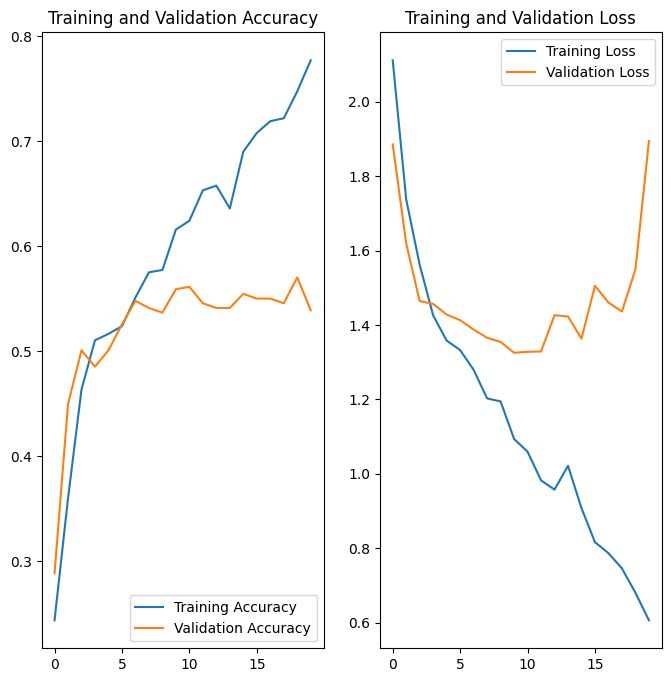

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### There is now such improvement in the model.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

<ipython-input-38-755c3fa95898>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="No. of Image", y="Class", data=df, palette="Paired",label="Class")


<Axes: xlabel='No. of Image', ylabel='Class'>

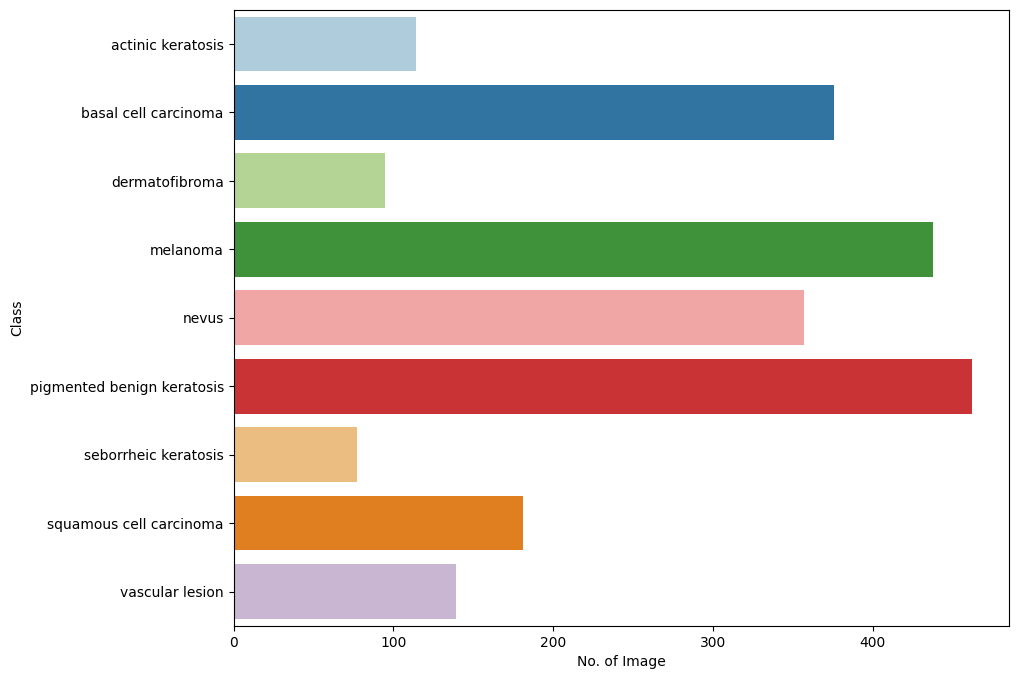

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, palette="Paired",label="Class")

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Seborrheic keratosis is having least no of samples.
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented bening keratosis is having more no of samples.


####  **Rectify the class imbalance**
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:

path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor

for i in class_names:
    path = path_to_training_dataset + '/' + i
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E00D351E5F0>: 100%|██████████| 500/500 [00:31<00:00, 16.12 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E00D35DA260>: 100%|██████████| 500/500 [00:22<00:00, 22.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E01C6437B50>: 100%|██████████| 500/500 [00:22<00:00, 22.03 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7E00D33B2D10>: 100%|██████████| 500/500 [01:32<00:00,  5.40 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7E010ABF5990>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E010B69F2E0>: 100%|██████████| 500/500 [00:26<00:00, 18.93 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E00D35C0DF0>: 100%|██████████| 500/500 [00:49<00:00, 10.10 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E011CEED270>: 100%|██████████| 500/500 [00:21<00:00, 23.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E00D35DBB80>: 100%|██████████| 500/500 [00:22<00:00, 22.17 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### **Lets see the distribution of augmented data after adding new images to the original training data.**

In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     /content/drive/MyDrive/Colab Notebooks/CNN_ass...  actinic keratosis
1     /content/drive/MyDrive/Colab Notebooks/CNN_ass...  actinic keratosis
2     /content/drive/MyDrive/Colab Notebooks/CNN_ass...  actinic keratosis
3     /content/drive/MyDrive/Colab Notebooks/CNN_ass...  actinic keratosis
4     /content/drive/MyDrive/Colab Notebooks/CNN_ass...  actinic keratosis
...                                                 ...                ...
2234  /content/drive/MyDrive/Colab Notebooks/CNN_ass...    vascular lesion
2235  /content/drive/MyDrive/Colab Notebooks/CNN_ass...    vascular lesion
2236  /content/drive/MyDrive/Colab Notebooks/CNN_ass...    vascular lesion
2237  /content/drive/MyDrive/Colab Notebooks/CNN_ass...    vascular lesion
2238  /content/drive/MyDrive/Colab Notebooks/CNN_ass...    vascular lesion

[2239 rows x 2 columns]

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_cd17086a-d62e-41b8-9f1a-857b40e45b83.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032437.jpg_96777e65-6889-4529-9033-dddd3df6ec52.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_7aee1f7b-dde9-451d-b788-072bc3ea005a.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_ea694768-2238-4bef-9996-53ede7b6459c.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Model 3: Train the model on the data created using Augmentor**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Create a training dataset**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Create a validation dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Create your model 3**

In [ ]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 43, 43, 64)       

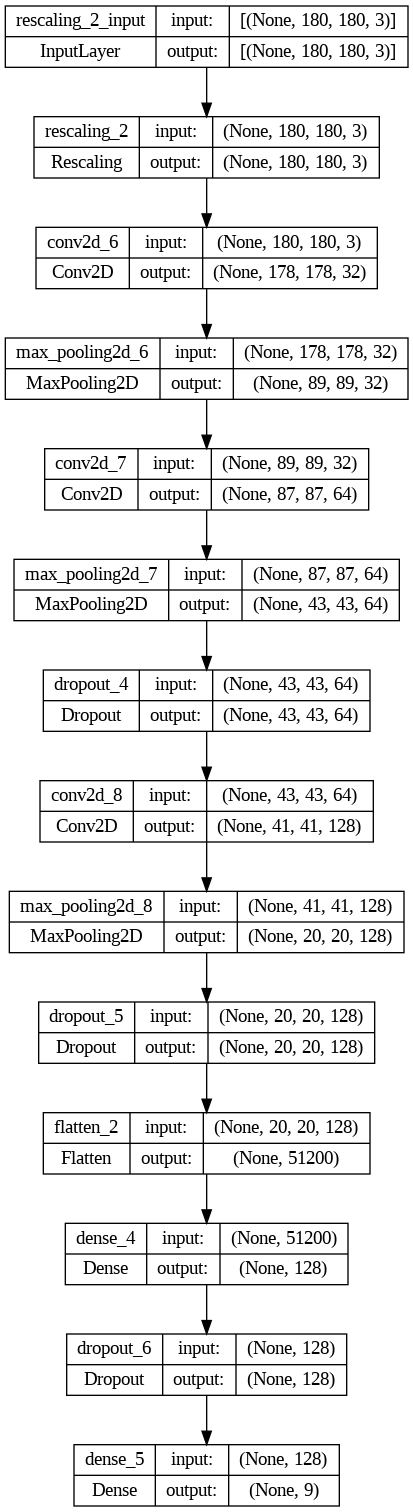

In [ ]:
# vizualizing the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 43, 43, 64)       

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 403s 2s/step - loss: 2.1520 - accuracy: 0.2192 - val_loss: 1.6871 - val_accuracy: 0.3846
Epoch 2/30
169/169 [==============================] - 394s 2s/step - loss: 1.6197 - accuracy: 0.3893 - val_loss: 1.4332 - val_accuracy: 0.4410
Epoch 3/30
169/169 [==============================] - 418s 2s/step - loss: 1.5034 - accuracy: 0.4269 - val_loss: 1.4430 - val_accuracy: 0.4402
Epoch 4/30
169/169 [==============================] - 451s 3s/step - loss: 1.3829 - accuracy: 0.4796 - val_loss: 1.2618 - val_accuracy: 0.5204
Epoch 5/30
169/169 [==============================] - 402s 2s/step - loss: 1.2606 - accuracy: 0.5295 - val_loss: 1.2871 - val_accuracy: 0.5033
Epoch 6/30
169/169 [==============================] - 383s 2s/step - loss: 1.1860 - accuracy: 0.5569 - val_loss: 1.1724 - val_accuracy: 0.5501
Epoch 7/30
169/169 [==============================] - 400s 2s/step - loss: 1.1034 - accuracy: 0.5818 - val_loss: 1.1837 - val_accuracy: 0.5716
Epoch 8/30

#### **Todo:**  Visualize the model results

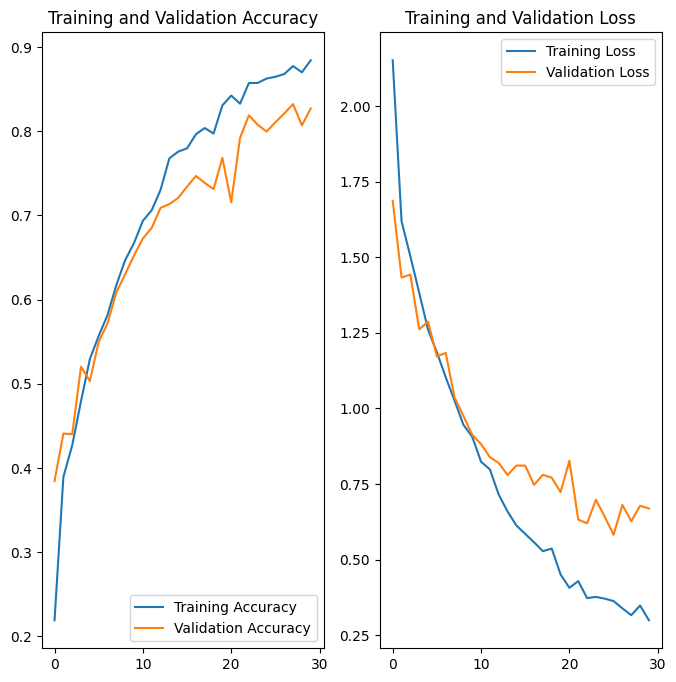

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####   Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Yes the overfitting issue is solved by using the class rebalancing as shown in the above graph the traning accuracy is app to 88% where as the testing accuracy is to 83%.
#### accuracy: 0.8843
#### loss: 0.3000
#### val_accuracy: 0.8270
#### val_loss: 0.6691


### Model Prediction

In [ ]:
def model_prediction(class_no):
  Test_image_path = os.path.join(data_dir_test, class_names[class_no], '*')
  Test_image = glob(Test_image_path)
  Test_image = load_img(Test_image[-class_no],target_size=(180,180,3))
  print(Test_image_path)
  plt.imshow(Test_image)
  plt.grid(False)

  img = np.expand_dims(Test_image,axis=0)
  pred = model.predict(img)
  pred = np.argmax(pred)
  pred_class = class_names[pred]
  print("Actual Class "+ class_names[class_no] +'\n'+ "Predictive Class "+pred_class )

/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/*
1/1 [==============================] - 0s 368ms/step
Actual Class pigmented benign keratosis
Predictive Class pigmented benign keratosis


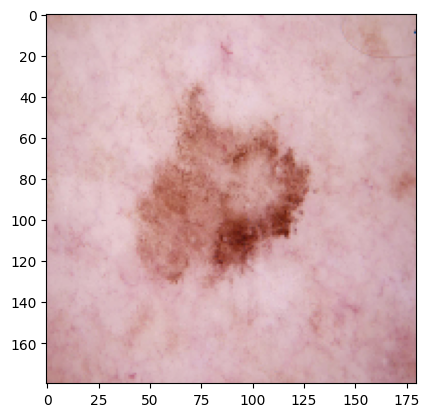

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[5], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-5],target_size=(180,180,3))
print(Test_image_path)
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[5] +'\n'+ "Predictive Class "+pred_class )

/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/*
1/1 [==============================] - 0s 33ms/step
Actual Class nevus
Predictive Class nevus


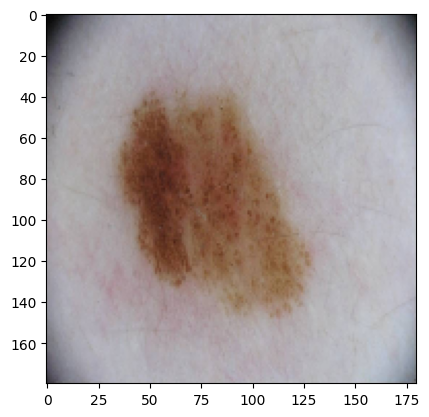

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[4], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
print(Test_image_path)
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[4] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 34ms/step
Actual Class vascular lesion
Predictive Class pigmented benign keratosis


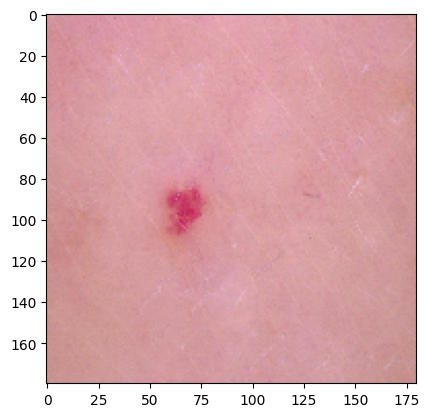

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[8], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[8] +'\n'+ "Predictive Class "+pred_class )

1/1 [==============================] - 0s 51ms/step
Actual Class squamous cell carcinoma
Predictive Class squamous cell carcinoma


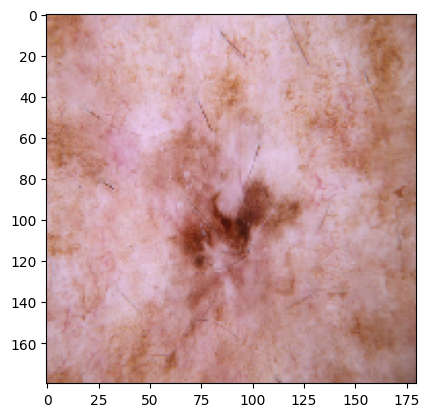

In [ ]:
Test_image_path = os.path.join(data_dir_test, class_names[7], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[7] +'\n'+ "Predictive Class "+pred_class )